<a href="https://colab.research.google.com/github/Deadfish-hk/AcuCount_imageset/blob/main/telegram_bot_colab_mmrotate_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# The starting script of the telegram detection bot.
# You can replace the .pth file and the.config into any object of your interest, after custom training.

In [1]:
# Mount the google drive if you are working with cloud drive. Comment out this section if you are working with local file system.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Clone the AcuCount Repo for dataset and configs
!git clone https://github.com/Deadfish-hk/AcuCount_imageset.git

Cloning into 'AcuCount_imageset'...
remote: Enumerating objects: 2091, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 2091 (delta 10), reused 0 (delta 0), pack-reused 2071
Receiving objects: 100% (2091/2091), 687.30 MiB | 40.57 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Updating files: 100% (2059/2059), done.


In [3]:
# Download the AcuCount model stored in Google drive for demostration
!pip install gdown
!gdown https://drive.google.com/uc?id=11qKHCZYwAelya_bHDej4xDTKu7k9eb8z

Downloading...
From (original): https://drive.google.com/uc?id=11qKHCZYwAelya_bHDej4xDTKu7k9eb8z
From (redirected): https://drive.google.com/uc?id=11qKHCZYwAelya_bHDej4xDTKu7k9eb8z&confirm=t&uuid=31dd6c3e-8e9a-4959-9167-af3799960818
To: /content/AcuCount_detection_model.pth
100% 330M/330M [00:10<00:00, 32.9MB/s]


In [ ]:
# install python-telegram-bot (13.14)
!pip install 'python-telegram-bot==13.14'

In [2]:
# Install dependencies: (use cu116 because colab has CUDA 11.6)
!pip install torch==1.12.1+cu116 torchvision==0.13.1+cu116 -f https://download.pytorch.org/whl/torch_stable.html

# Install mmcv-full and mmdetection thus we could use CUDA operators
!pip3 install -U openmim
!mim install mmcv-full==1.6.2
!mim install mmdet==2.26.0

# Install mmrotate
!git clone --branch v0.3.4 https://github.com/open-mmlab/mmrotate.git
%cd mmrotate
!pip install -e .

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu116/torch1.12.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 6.0 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu116/torch1.12.0/index.html
  Using cached mmdet-2.26.0-py3-none-any.whl (1.4 MB)
Cloning into 'mmrotate'...
remote: Enumerating objects: 3853, done.
remote: Counting objects: 100% (1244/1244), done.
remote: Compressing objects: 100% (383/383), done.
remote: Total 3853 (delta 959), reused 886 (delta 861), pack-reused 2609
Receiving objects: 100% (3853/3853), 25.26 MiB | 17.42 MiB/s, done.
Resolving deltas: 100% (2378/2378), done.
Note: switching to '7755aa53b6e2d9c61fd765e67a60daa7ed8a1e05'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any c

In [3]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMRotate installation
import mmrotate
print(mmrotate.__version__)

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.12.1+cu116 True
0.3.4
2.26.0
11.6
GCC 9.3


In [4]:
import mmcv
from mmcv.runner import load_checkpoint
from mmdet.apis import inference_detector, show_result_pyplot
from mmrotate.models import build_detector

# Choose to use a config and initialize the detector
config = '/content/AcuCount_imageset/AcuCount_detection_model_config.py'   # Insert link to Config file here
# Setup a checkpoint file to load
checkpoint = '/content/AcuCount_detection_model.pth' # Insert link to checkpoint file here

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

/usr/local/lib/python3.10/dist-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: /content/AcuCount_detection_model.pth


OrientedRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [5]:
import numpy as np

def counting(result):     # Count the number of detections found.
  count = 0
  count_order = 0
  count_list = result[0]
  for item in np.nditer(count_list):
    box_score = count_list[count_order][5]
    if box_score > 0.5:
      count = count + 1
      count_order = count_order + 1
      if count_order == len(count_list):
        break
    if box_score < 0.5:
      count_order = count_order + 1
      if count_order == len(count_list):
        break
  return count

/usr/local/lib/python3.10/dist-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


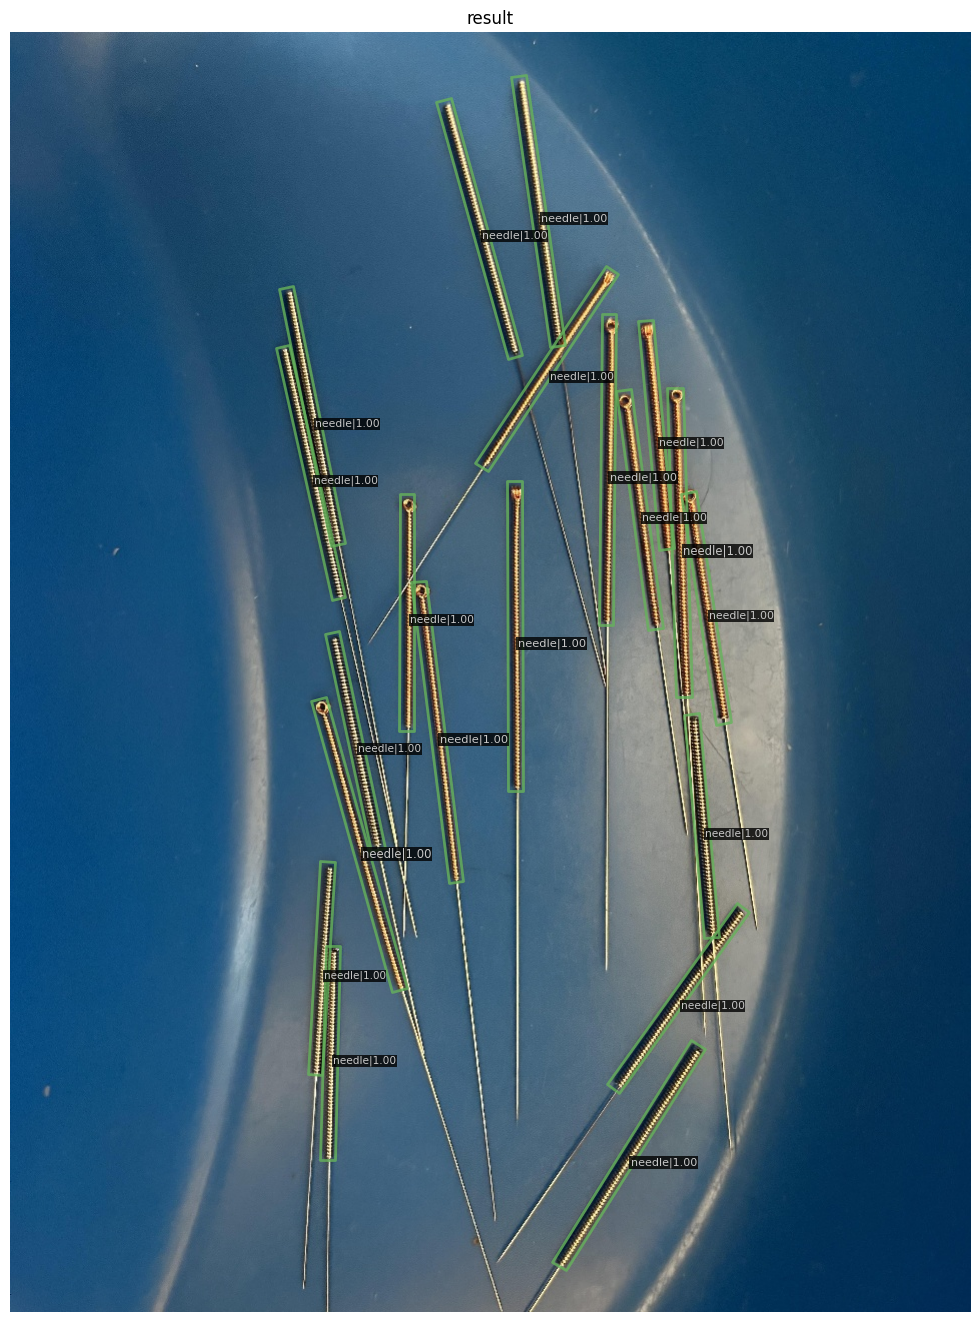

20


In [9]:
# This cell is intended for internal validation of the dataset, after the loading of the necessary model and functions.
# By default, the image path was set to the first picture in our copper_and_silver needle set. You may change change the image_path if needed.
# The result image should appear the same as the validation record.
image_path = f'/content/AcuCount_imageset/Validation_imageset/Copper_and_Silver_validation/Copper_and_Silver_0001.jpg'
result = inference_detector(model, img)
count = counting(result)
show_result_pyplot(model, img, result, score_thr=0.5)
print (f'{count}')


In [ ]:
import telegram
import numpy as np
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters
import logging
from datetime import datetime
from PIL import Image
import time
import mmcv
from mmcv.runner import load_checkpoint
from mmdet.apis import inference_detector, show_result_pyplot
from mmrotate.models import build_detector
import os

bot = telegram.Bot(token='xx')  # Insert your telegram bot token here

updater = Updater(token='xx', use_context=True)  # Insert your telegram bot token here

dispatcher = updater.dispatcher

# Set up logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='/content/drive/MyDrive/processed_images_record/timeevent.log', mode='a')  # Setup your log file for recording end-end counting time
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

dim = (960, 1280)

# Welcome message
def start(update, context):
    context.bot.send_message(chat_id=update.effective_chat.id, text="Send me a photo with needles then I will do the detection for you!"
                            )
    context.bot.send_photo(chat_id=update.effective_chat.id, photo=open('/content/drive/MyDrive/telegrambot_config/start_image.png', 'rb')) # Place your example detection here

def detection_image(update, context):
    photos = update.message.photo
    documents = update.message.document
    # timestamp in UTC time
    now = datetime.now()
    timestamp_date = now.strftime("%Y%m%d")
    timestamp_time = now.strftime("%H%M%S")
    if photos:
        user = update.message.from_user
        update.message.reply_text("I have received your image. Now detecting needles..\nIt may take 5 seconds to process.. ")
        logger.info(f"Photo received from {user.first_name} {user.last_name}")
        start_time = time.time()
        # Download the 960x1280 photo
        photo_id = photos[-1].file_id
        context.bot.get_file(photo_id).download(f"/content/drive/MyDrive/downloaded_images_record/{timestamp_date}-{timestamp_time}.jpg")  # Download the incoming image in your Gdrive directory. By default it is directed to be /downloaded_images_record under your Gdrive.
        image_path = f'/content/drive/MyDrive/downloaded_images_record/{timestamp_date}-{timestamp_time}.jpg' # Download the incoming image in your Gdrive directory. By default it is directed to be /downloaded_images_record under your Gdrive.
        img = mmcv.imread(image_path)
        result = inference_detector(model, img)
        count = counting(result)
        show_result_pyplot(model, img, result, score_thr=0.5, out_file= f'/content/drive/MyDrive/processed_images_record/{count}-{timestamp_date}-{timestamp_time}.jpg') # Process the incoming image and store it in your Gdrive. By default it is directed to be /processed_images_record under your Gdrive.
    elif documents.mime_type == 'image/heic' or 'image/jpeg' or 'image/png':
        user = update.message.from_user
        update.message.reply_text("I have received your image. Now detecting needles..\nIt may take 5 seconds to process.. ")
        logger.info(f"H-res Photo received from {user.first_name} {user.last_name}")
        start_time = time.time()
        # Download the uncompressed photo
        context.bot.get_file(documents.file_id).download(f"/content/drive/MyDrive/downloaded_images_record/{timestamp_date}-{timestamp_time}.jpg") # Download the incoming image in your Gdrive directory. By default it is directed to be /downloaded_images_record under your Gdrive.
        simg = Image.open(f"/content/drive/MyDrive/downloaded_images_record/{timestamp_date}-{timestamp_time}.jpg") # Download the incoming image in your Gdrive directory. By default it is directed to be /downloaded_images_record under your Gdrive.
        #simg_resized = simg.resize (dim)
        #simg_resized.save(f"/content/drive/MyDrive/downloaded_images_record/{timestamp_date}-{timestamp_time}_resized.jpg") # Reserved for any necessary resizing effort
        image_path = f'/content/drive/MyDrive/downloaded_images_record/{timestamp_date}-{timestamp_time}.jpg'
        img = mmcv.imread(image_path)
        result = inference_detector(model, img)
        count = counting(result)
        show_result_pyplot(model, img, result, score_thr=0.5, out_file= f'/content/drive/MyDrive/processed_images_record/{count}-{timestamp_date}-{timestamp_time}.jpg') # Process the incoming image and store it in your Gdrive. By default it is directed to be /processed_images_record under your Gdrive.

    update.message.reply_text(f"Needle count:{count}")
    update.message.reply_photo(open(f'/content/drive/MyDrive/processed_images_record/{count}-{timestamp_date}-{timestamp_time}.jpg','rb'))
    end_time = time.time()
    elapsed_time = end_time - start_time
    logger.info(f"Photo sent to {user.first_name} {user.last_name}, elapsed time:{elapsed_time}")
    # Rename image for easy reference
    OLD_DOWNLOAD = f'/content/drive/MyDrive/downloaded_images_record/{timestamp_date}-{timestamp_time}.jpg'
    NEW_DOWNLOAD = f'/content/drive/MyDrive/downloaded_images_record/{timestamp_date}-{timestamp_time}_{user.first_name}_{user.last_name}.jpg'
    OLD_PROCESS = f'/content/drive/MyDrive/processed_images_record/{count}-{timestamp_date}-{timestamp_time}.jpg'
    NEW_PROCESS = f'/content/drive/MyDrive/processed_images_record/{count}-{timestamp_date}-{timestamp_time}_{user.first_name}_{user.last_name}.jpg'
    os.renames (OLD_DOWNLOAD,NEW_DOWNLOAD)
    os.renames (OLD_PROCESS,NEW_PROCESS)

start_handler = CommandHandler('start', start)
dispatcher.add_handler(start_handler)
dispatcher.add_handler(MessageHandler(Filters.photo | Filters.document, detection_image))

updater.start_polling()



In [ ]:
# Stop the running telegram bot
updater.stop()